In [1]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

2024-11-06 22:49:19.822465: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 22:49:19.870210: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 22:49:20.226861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-06 22:49:20.560941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730913560.884653    3424 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730913560.96

In [2]:

# Import necessary libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum, col, hour, concat_ws, to_date, date_format
# Stop any existing Spark session
# Step 1: Initialize a Spark session
spark = SparkSession.builder \
    .appName("BigDataProcessing") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()
# Step 2: Load your CSV file into a Spark DataFrame
data = spark.read.csv(["June2024.csv", "July2024.csv", "aug.csv"], header=True, inferSchema=True)


your 131072x1 screen size is bogus. expect trouble
24/11/06 22:49:29 WARN Utils: Your hostname, J4Hp resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/11/06 22:49:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/06 22:49:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ERROR:root:Exception while sending command.================>      (24 + 3) / 27]
Traceback (most recent call last):
  File "/home/jeev/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=73>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  F

Py4JError: An error occurred while calling o31.csv

In [ ]:
    
# Step 3: Convert 'TICKET_ISSUE_DATE' to the correct format (DD/MM/YYYY to YYYY-MM-DD)
data = data.withColumn("TICKET_ISSUE_DATE", to_date(col("TICKET_ISSUE_DATE"), "dd/MM/yyyy"))

# Step 4: Extract hour from 'TICKET_ISSUE_TIME' and combine with 'TICKET_ISSUE_DATE'
# Extract hour as a two-digit string and concatenate with the formatted date
data = data.withColumn("TICKET_ISSUE_HOUR", date_format(col("TICKET_ISSUE_TIME"), "HH"))
data = data.withColumn("DATE_HOUR", concat_ws(" ", date_format(col("TICKET_ISSUE_DATE"), "yyyy-MM-dd"), col("TICKET_ISSUE_HOUR")))

# Step 5: Group by 'DATE_HOUR' and calculate the sum for 'NO_OF_ADULT' and 'NO_OF_CHILD'
summary_data = data.groupBy("DATE_HOUR") \
    .agg(
        spark_sum("NO_OF_ADULT").alias("NO_OF_ADULT"),
        spark_sum("NO_OF_CHILD").alias("NO_OF_CHILD")
    )
# Step 5: Convert Spark DataFrame to pandas DataFrame for further processing
df = summary_data.toPandas()
df


,DATE_HOUR,NO_OF_ADULT,NO_OF_CHILD
0,2024-06-15 08,10777,162
1,2024-06-18 06,10133,55
2,2024-06-01 00,1051,2
3,2024-06-18 11,18539,88
4,2024-06-18 09,10996,87
...,...,...,...
616,2024-06-02 22,133,1
617,2024-06-12 22,118,0
618,2024-06-05 23,403,2
619,2024-06-12 23,474,2


In [5]:
import pandas as pd
# Step 7: Convert 'DATE_HOUR' to datetime format, then set as the index
df['DATE_HOUR'] = pd.to_datetime(df['DATE_HOUR'], format='%Y-%m-%d %H')
df.set_index('DATE_HOUR', inplace=True)
df.sort_index(inplace=True)
print(df)


                     NO_OF_ADULT  NO_OF_CHILD
DATE_HOUR                                    
2024-05-31 01:00:00          242            0
2024-05-31 02:00:00          531            0
2024-05-31 03:00:00          827            0
2024-05-31 04:00:00          671            0
2024-05-31 05:00:00          488            1
...                          ...          ...
2024-06-30 13:00:00         9202          191
2024-06-30 14:00:00         4841           75
2024-06-30 15:00:00         1387           10
2024-06-30 16:00:00          232            6
2024-06-30 17:00:00            5            0

[621 rows x 2 columns]


In [6]:
# Step 7: Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)
print(scaled_data)


[[0.00810493 0.        ]
 [0.01782411 0.        ]
 [0.02777871 0.        ]
 ...
 [0.04661174 0.02941176]
 [0.00776862 0.01764706]
 [0.00013452 0.        ]]


In [7]:
# Step 8: Stop the Spark session
spark.stop()

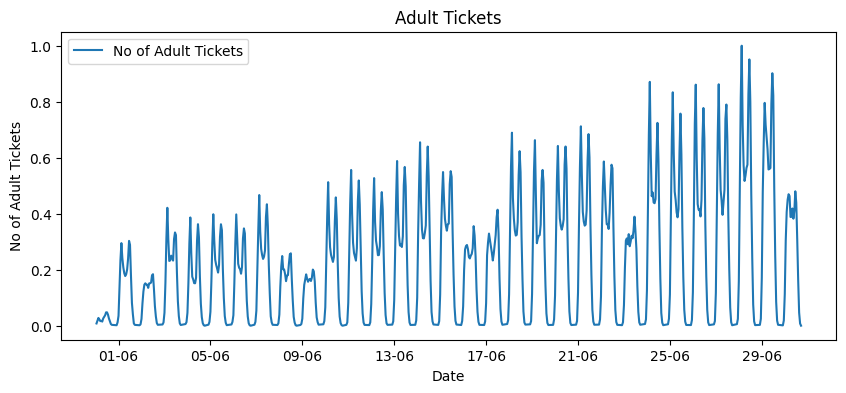

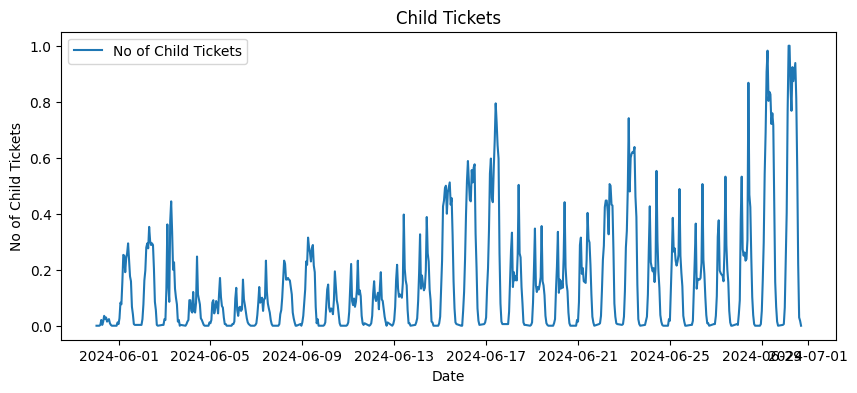

In [8]:
import matplotlib.dates as mdates

# Adult Tickets
plt.figure(figsize=(10, 4))
adult_scaled = [x for x, y in scaled_data]
plt.plot(df.index, adult_scaled, label='No of Adult Tickets')
plt.title('Adult Tickets')
plt.xlabel('Date')
plt.ylabel('No of Adult Tickets')
plt.legend()

# Set date format to only day and month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# Set major ticks to appear every 4 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.show()

# Child Tickets
plt.figure(figsize=(10, 4))
child_scaled = [y for x, y in scaled_data]
plt.plot(df.index, child_scaled, label='No of Child Tickets')
plt.title('Child Tickets')
plt.xlabel('Date')
plt.ylabel('No of Child Tickets')
plt.legend()


plt.show()


In [ ]:

# Step 9: Prepare Train and Test Data
split_ratio = 0.8
split_index = int(len(scaled_data) * split_ratio)     
# Create Train and Test datasets
Train = scaled_data[:split_index]
Test = scaled_data[split_index:]

In [11]:
# Step 10: Create TimeseriesGenerator for training data
n_input = 24  # Use the last 24 hours for prediction
n_features = 2  # Number of features (NO_OF_ADULT and NO_OF_CHILD)

generator = TimeseriesGenerator(Train, Train, length=n_input, batch_size=1)


In [12]:
# Define the LSTM model
model = Sequential([
    Bidirectional(LSTM(units=100, activation='tanh', return_sequences=True), input_shape=(n_input, n_features)),
    Bidirectional(LSTM(units=50, activation='tanh')),
    Dense(units=n_features, activation='linear')  # 'linear' is appropriate for regression
])

2024-11-04 09:57:58.693143: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jeev/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# compile the model

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [15]:
# model training
# Train the model
epochs = 25  # More epochs can lead to better performance
history = model.fit(generator, epochs=epochs, verbose=1)

Epoch 1/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0020 - mae: 0.0313
Epoch 2/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0021 - mae: 0.0306
Epoch 3/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0022 - mae: 0.0323
Epoch 4/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0018 - mae: 0.0306
Epoch 5/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0015 - mae: 0.0263
Epoch 6/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0021 - mae: 0.0307
Epoch 7/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0021 - mae: 0.0303
Epoch 8/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0019 - mae: 0.0303
Epoch 9/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0019 - mae: 0.0302
Epoch 10/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0015 - mae: 0.0265
Epoch 11/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0023 - mae: 0.0315
Epoch 12/25
410/410 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.0015 - mae: 0.0263
E

KeyboardInterrupt: 

In [ ]:

# Step 14: Generate sequences for the test data
test_generator = TimeseriesGenerator(Test, Test, length=n_input, batch_size=1)

# Step 15: Make predictions
predictions = model.predict(test_generator)

# Step 16: Inverse transform the predictions and actual test data
predicted_values = scaler.inverse_transform(predictions)
actual_values = scaler.inverse_transform(Test[n_input:])  # Use Test[n_input:] for matching lengths


163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


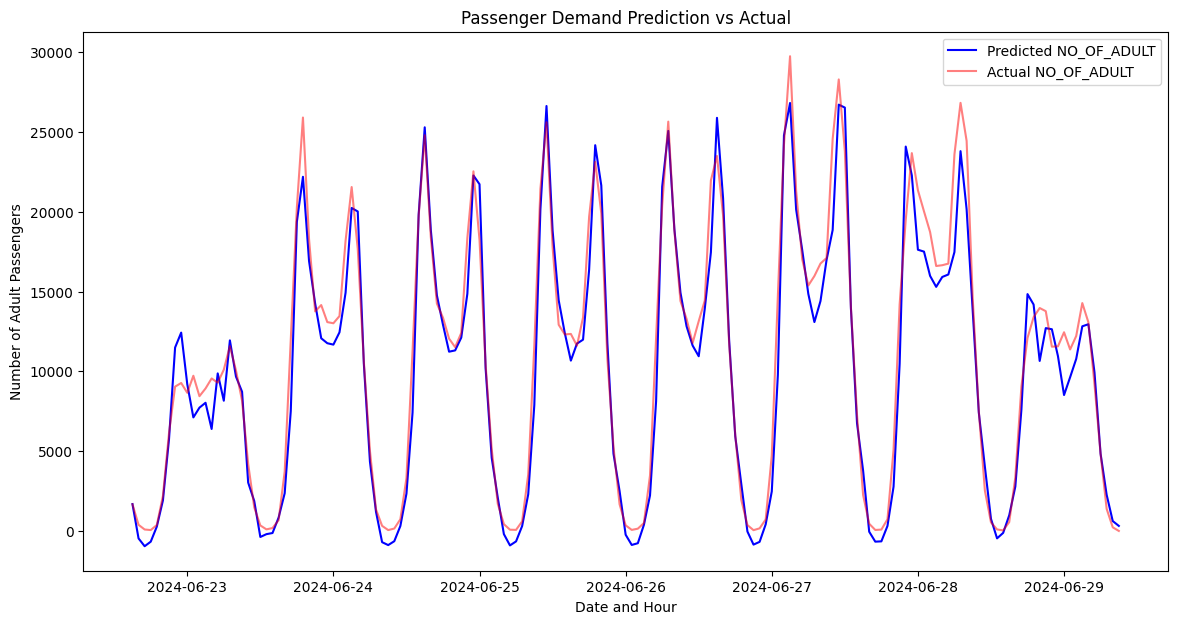

In [ ]:
# Step 17: Create a time index for the predicted values
time_index = pd.date_range(start=df.index[split_index + n_input], periods=len(predicted_values), freq='H')

# Step 18: Create a DataFrame for the predicted and actual values for better visualization
results = pd.DataFrame({
    'Predicted_NO_OF_ADULT': predicted_values[:, 0],
    'Predicted_NO_OF_CHILD': predicted_values[:, 1],
    'Actual_NO_OF_ADULT': actual_values[:, 0],
    'Actual_NO_OF_CHILD': actual_values[:, 1],
}, index=time_index)

# Step 19: Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Predicted_NO_OF_ADULT'], label='Predicted NO_OF_ADULT', color='blue')
plt.plot(results.index, results['Actual_NO_OF_ADULT'], label='Actual NO_OF_ADULT', color='red', alpha=0.5)
plt.title('Passenger Demand Prediction vs Actual')
plt.xlabel('Date and Hour')
plt.ylabel('Number of Adult Passengers')
plt.legend()
plt.show()

